# WOS 批量论文自动化分析

In [1]:
import os
import pandas as pd
import openpyxl
import collections

## 1 数据预处理模块

### 1.1 数据清洗

In [2]:
from data_clean import coreDataSelect as data_clean
inputFile1 = 'savedrecs.xls'
outputFile1 = data_clean(inputFile1)

### 1.2 检查清洗数据

In [3]:
df = pd.read_excel(outputFile1)
df.columns

Index(['Title', 'Source', 'Keywords', 'WOS_Keywords', 'Abstract', 'Addresses',
       'Affiliations', 'Cited', 'Publication_Year', 'DOI', 'Research_Areas'],
      dtype='object')

## 2 词频统计模块

### 2.1 合并关键词列并进行文本预处理

In [4]:
# 先将关键词列合并，再进行文本预处理，最后返回关键词列表
def all_keywords(inputFile):
    df = pd.read_excel(inputFile)
    # 以分号合并两列关键词内容，并以分号切割成列表，需要注意的是 "; " 而不是 ";"
    keywords = df["Keywords"].str.cat(sep="; ") + df["WOS_Keywords"].str.cat(sep="; ")
    # keywords = df["作者关键词"].str.cat(sep="; ")
    word_list = keywords.split("; ")
    # 判断每个词组是否包含数字，如果包含数字，就保留-，否则就将-替换为空格
    word_list = [w if any(c.isdigit() for c in w) else w.replace("-", " ") for w in word_list]
    # 使用列表推导式和 str.title () 方法将列表中的字符串全部转换为首字母大写
    # str.upper () 全体大写
    word_list_upper = [w.title() for w in word_list]
    # 使用正则表达式匹配括号里的单词，并将其转换为大写
    import re
    word_list_upper = [re.sub(r"\((\w+)\)", lambda m: "(" + m.group(1).upper() + ")", w) for w in word_list_upper]
    # 使用列表推导式和len()函数判断每个单词的长度，并将长度小于等于三的单词转换为大写
    word_list_upper = [w.upper() if len(w) <= 3 else w for w in word_list_upper]
    return word_list_upper


### 2.2 关键词同义合并

In [5]:
# 关键词同义合并，并返回合并后的单词列表
def synonymMerge(inputFile):
    word_list = all_keywords(inputFile)
    # 读取映射表
    df = pd.read_excel("../data/input/related_terms.xlsx")
    mapping_dict = dict(zip(df["Original_Word"], df["Mapping_Word"]))
    # 创建一个空列表用于存储转化后的元素
    transformed_list = []
    # 遍历word_list列表中的每个元素
    for word in word_list:
        # 如果元素在字典中有对应的键，则用字典中的值替换它，否则保持不变
        new_word = mapping_dict.get(word, word)
        # 将转化后的元素添加到新列表中
        transformed_list.append(new_word)    
    # 返回合并后的列表类型的数据
    return transformed_list

### 2.3 关键词词频统计

In [6]:
def wordCount(inputFile, outputFile):
    # 同义词替换
    word_list = synonymMerge(inputFile)
    # 使用collections进行词频统计，获取前300个高频词及其出现次数
    # 返回一个字典，键为分词，值为出现次数
    word_counts = collections.Counter(word_list)
    # 返回一个列表，每个元素是一个元组，包含分词和出现次数
    word_counts_top300 = word_counts.most_common(300)
    # 将词频统计的结果导出成新的excel文档
    # 创建一个数据框存放列表数据
    df_word_counts = pd.DataFrame(word_counts_top300, columns=["Keyword", "Count"])
    # 导出数据到excel文件，并去掉索引列
    df_word_counts.to_excel(outputFile, index=False)

In [7]:
inputFile2 = outputFile1
outputFile2 = "../data/output/keyword_count.xlsx"
wordCount(inputFile2, outputFile2)

## 3 翻译模块

### 3.1 腾讯云机器翻译

In [8]:
# 批量翻译
def keywords_tranlate(source_file, source_column, target_file):
    import tencent_translate
    tencent_translate.write_results(source_file, source_column, target_file)

In [9]:
# source_file = outputFile2
# target_file = "../data/output/test_tranlate_counts.xlsx"
# keywords_tranlate(source_file, "原文标题", target_file, "标题翻译")

In [10]:
inputFile3 = outputFile2
outputFile3 = "../data/output/keyword_tranlate_counts.xlsx"
keywords_tranlate(inputFile3, "Keyword", outputFile3)

## 4 词云图模块

### 4.1 关键词词云绘制

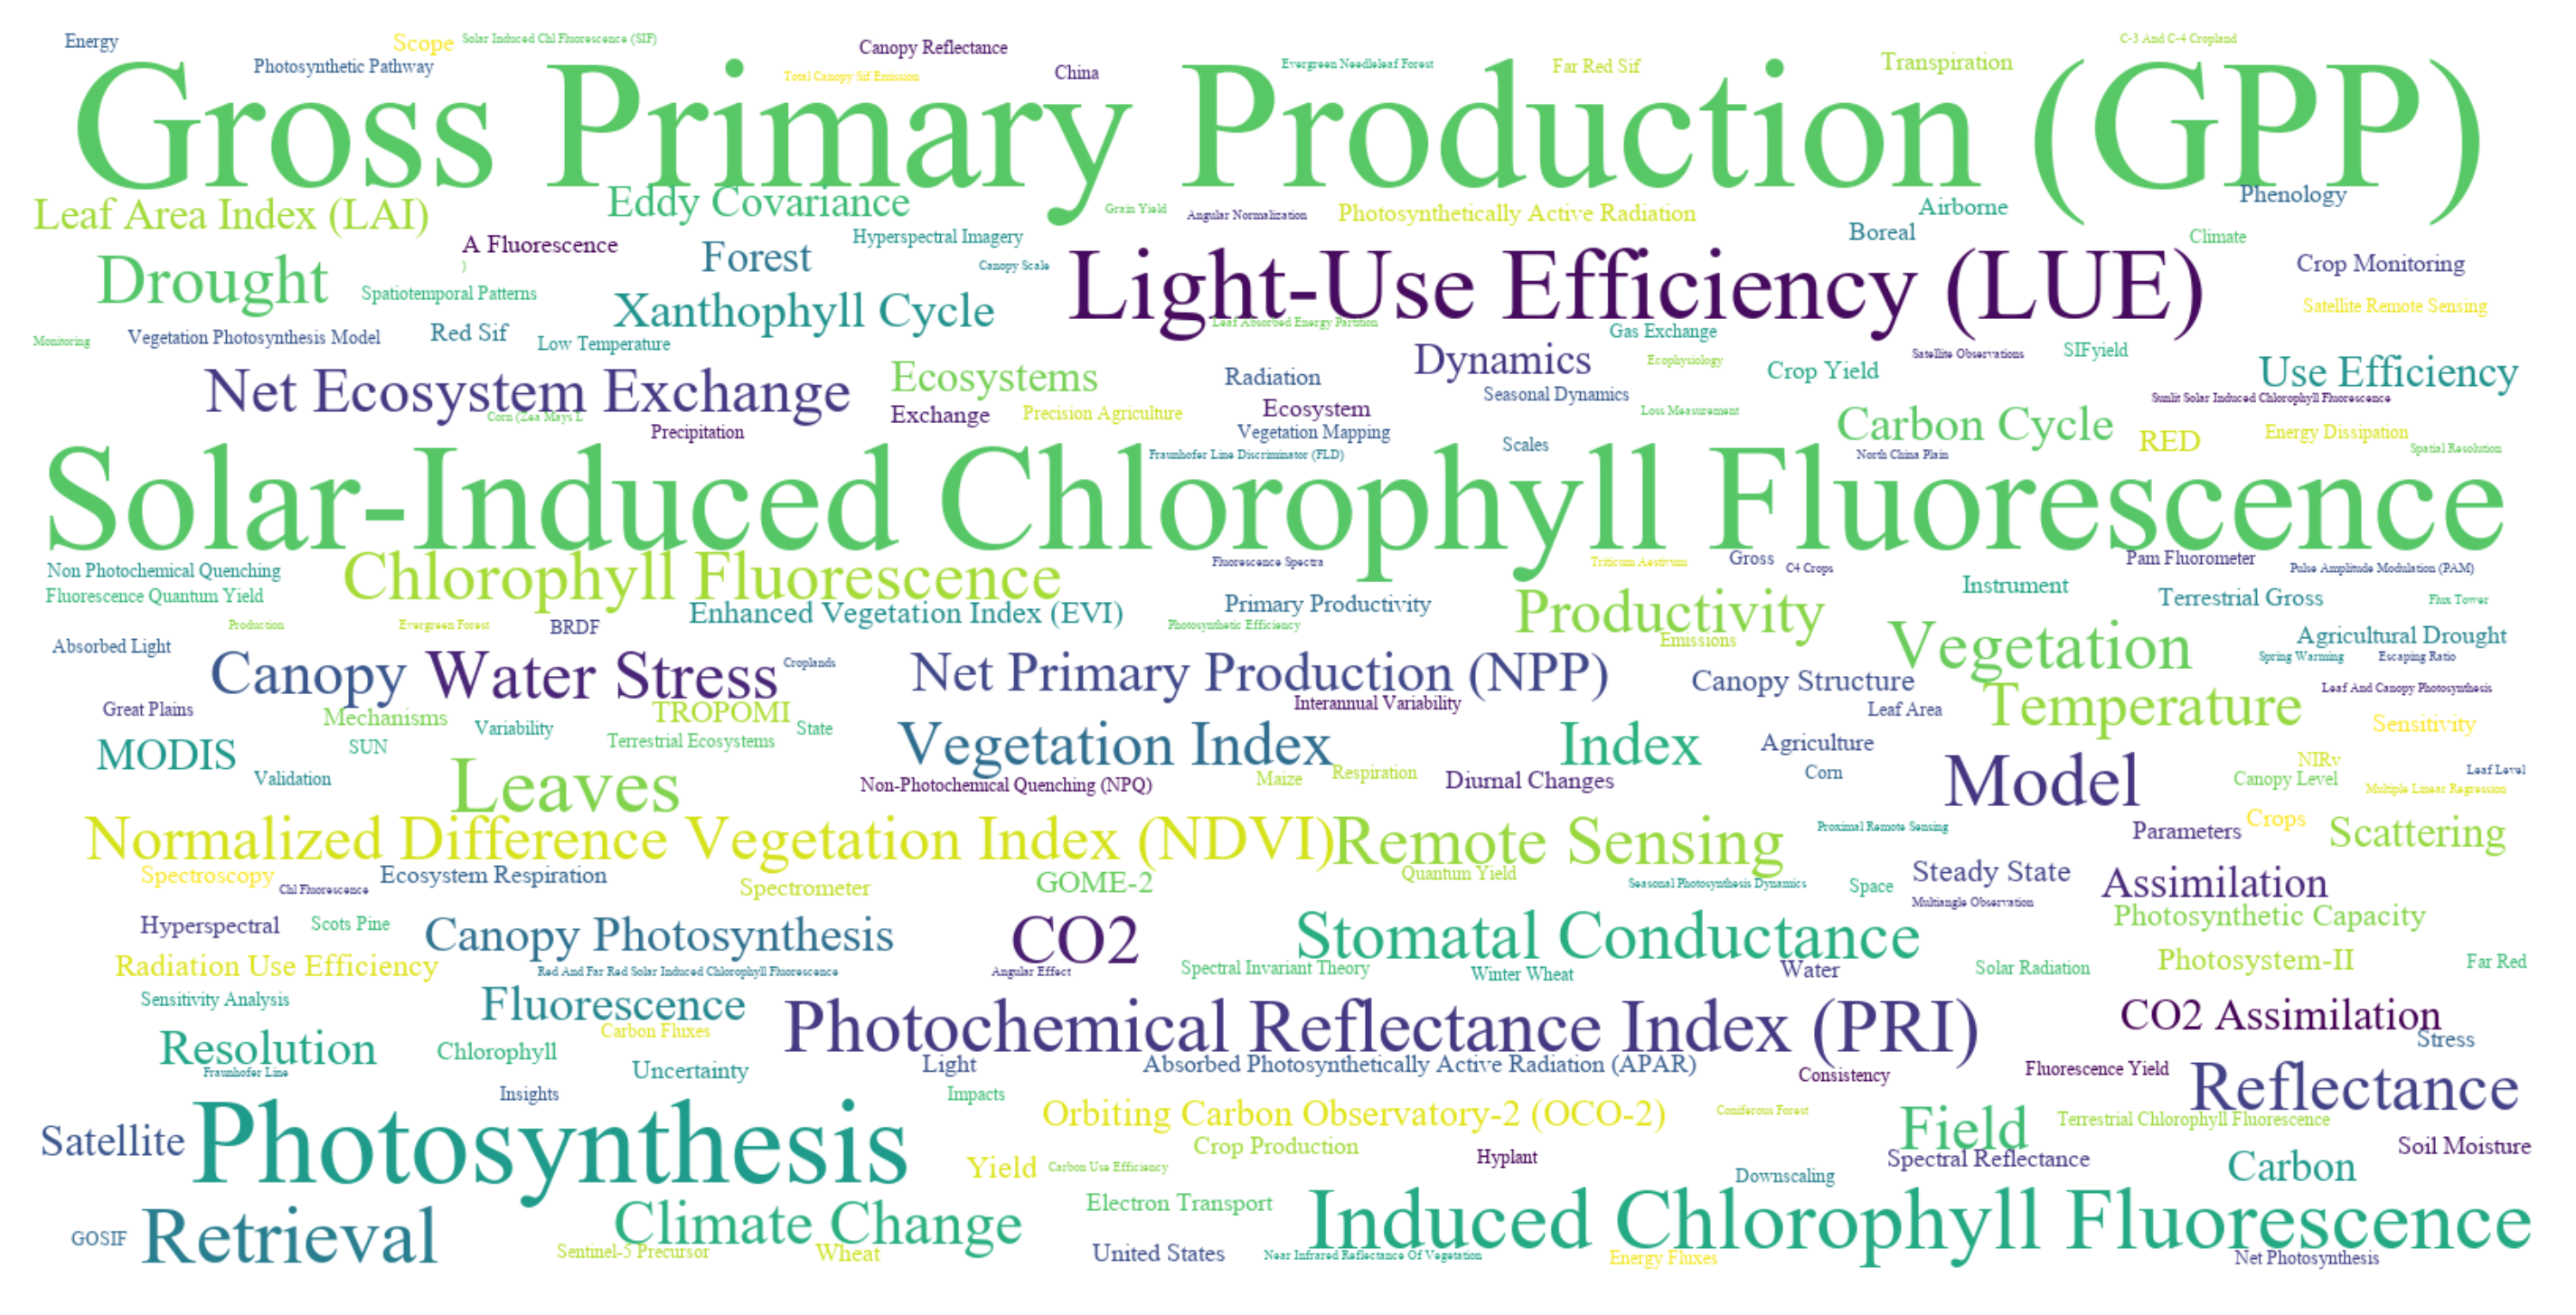

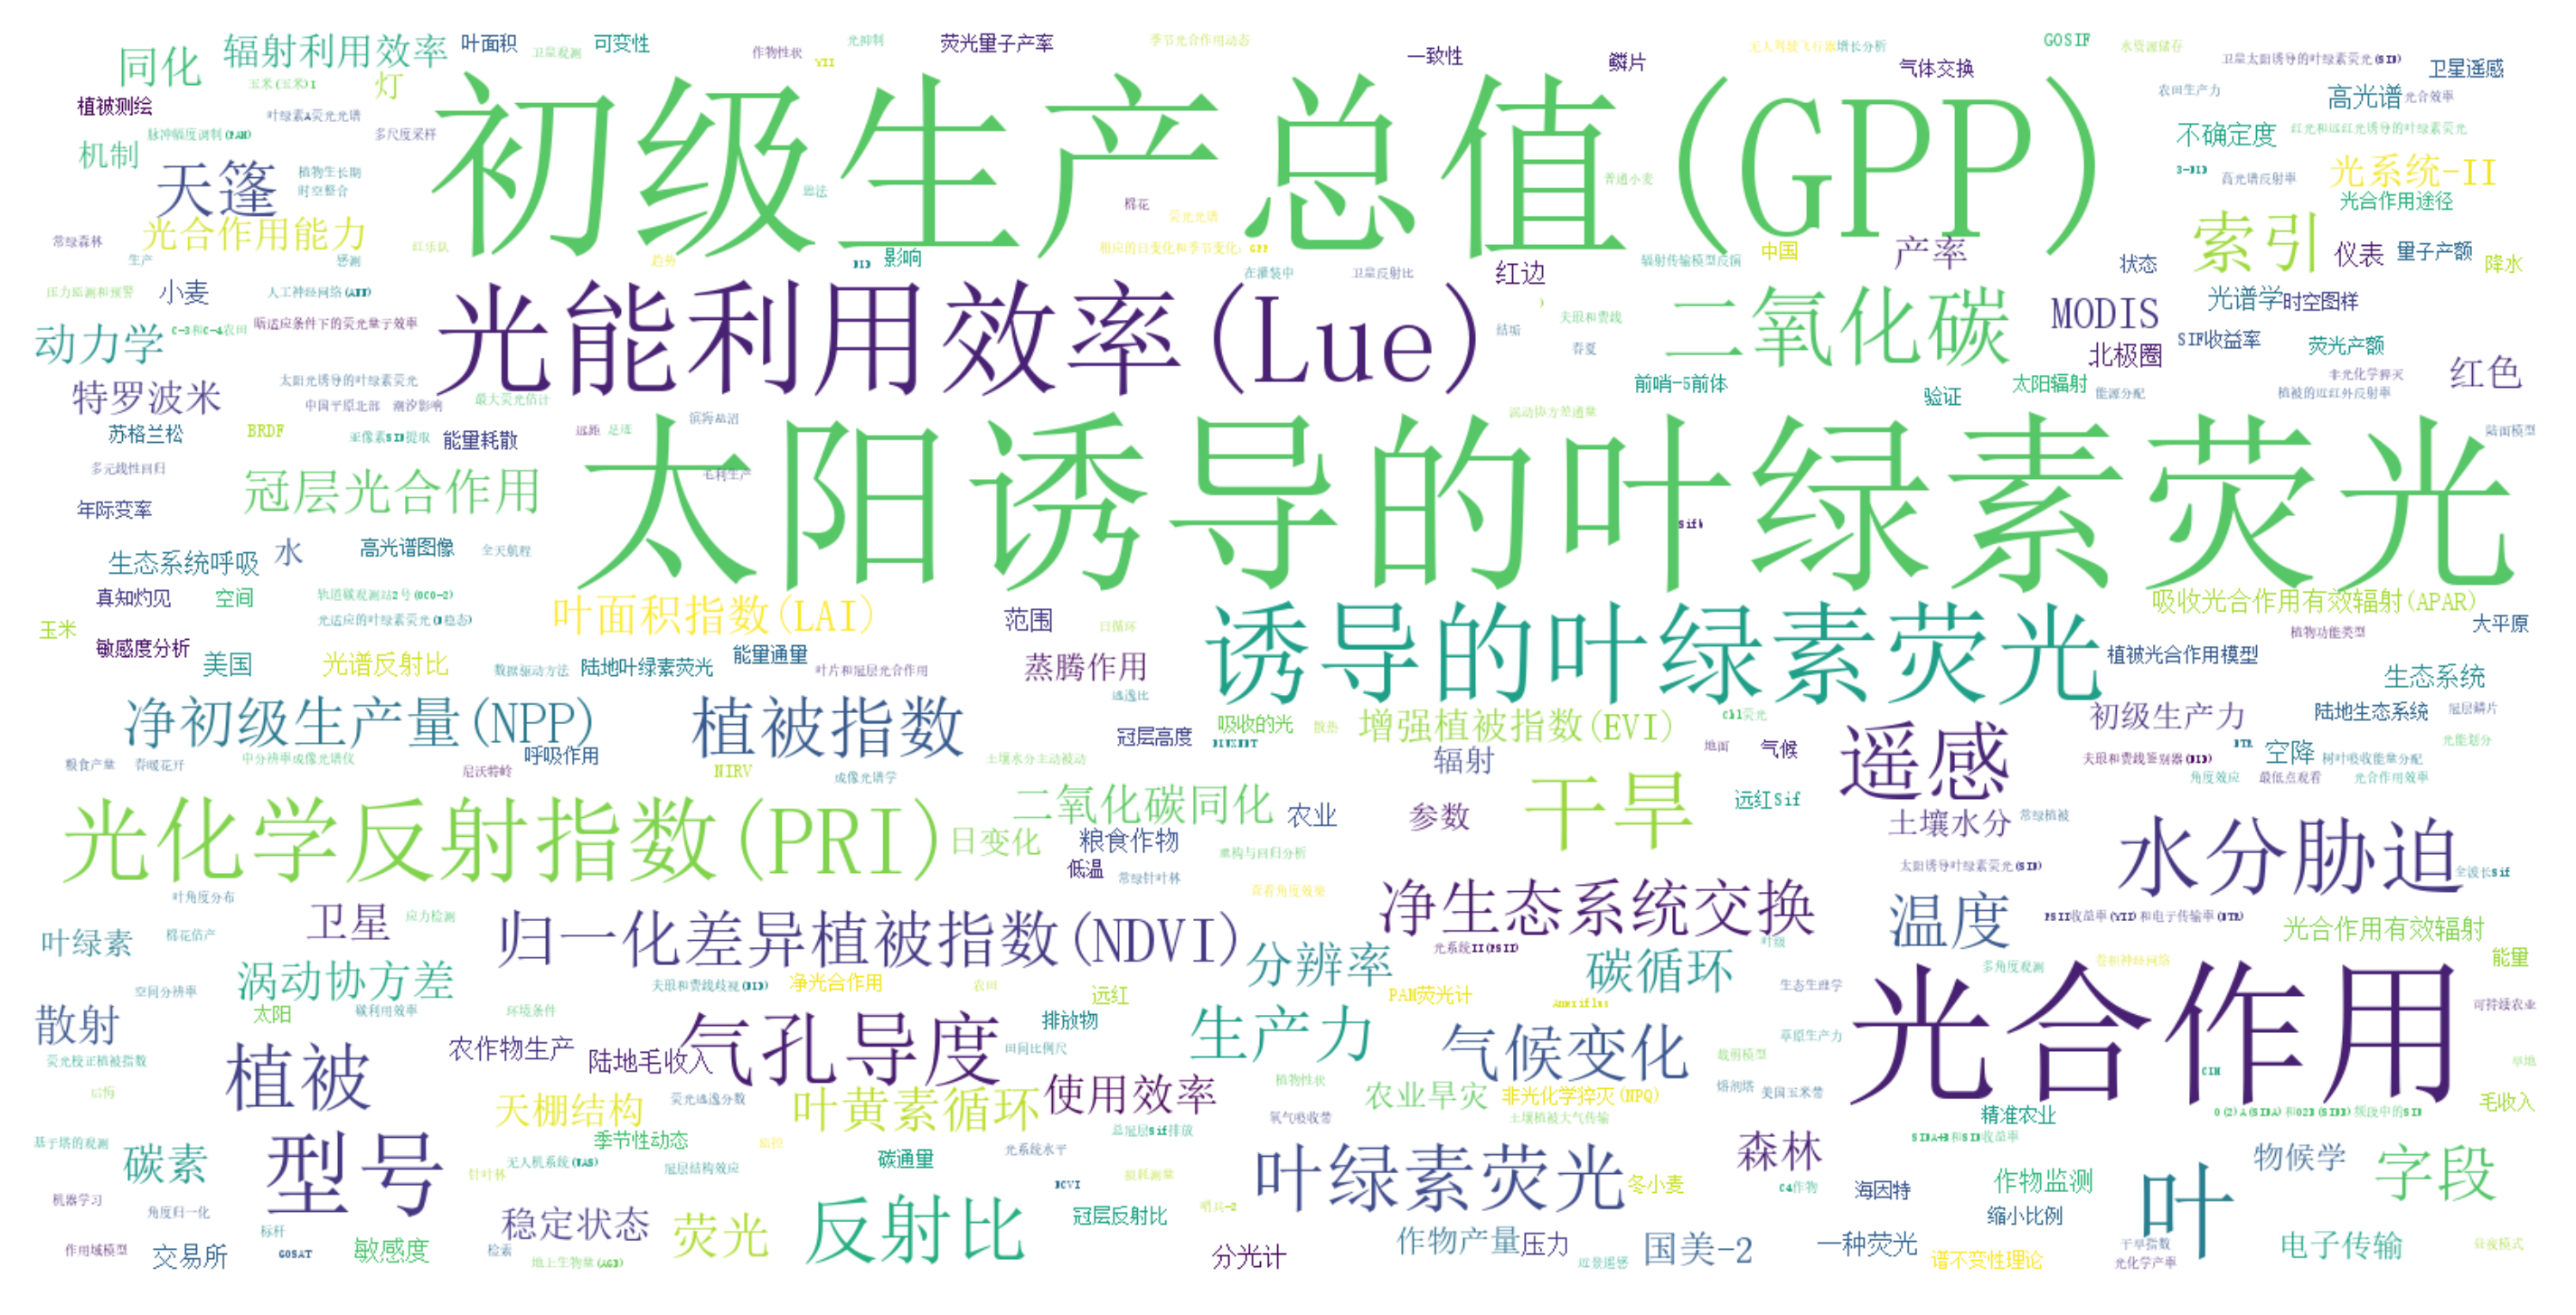

In [11]:
from words_cloud import keywordCloud
keywordCloud(outputFile3)
keywordCloud(outputFile3, lang='zh')